In [1]:
# !git clone https://github.com/hannahpu/widsdatathon2022.git
# ! ls ./widsdatathon2022
# ! pip install nb-black

In [2]:
# ! ls ..

In [3]:
from datetime import datetime
import sys

import pandas as pd
import catboost as cb
import xgboost as xgb

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Will need enable_iterative_imputer import otherwise IterativeImputer
# gives import error
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

sys.path.append("..")
import global_vars as gv
from utils import model_utils as mu
from utils import data_utils as du
from utils import data_process_utils as dpu
from utils import visualize as viz

%load_ext nb_black

today = datetime.today().date()
print(today)

2022-02-25


<IPython.core.display.Javascript object>

In [4]:
wids_path = "../"

<IPython.core.display.Javascript object>

In [5]:
test_df = pd.read_csv("../data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv("../data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv("../data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [6]:
display(train_df.state_factor.value_counts())
display(test_df.state_factor.value_counts())

# display(train_df.query("state_factor == 'State_6'").year_factor.value_counts())
# for state in train_df.state_factor.unique():
#     print(state)
#     display(train_df.query("state_factor == @state").year_factor.value_counts())

# Upsample by two columns?
display(train_df.year_factor.value_counts())

display(train_df.groupby(["state_factor", "year_factor"]).count())

State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: state_factor, dtype: int64

State_11    3268
State_4     2568
State_2     1515
State_8     1323
State_1     1027
State_10       4
Name: state_factor, dtype: int64

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: year_factor, dtype: int64

building_class  facility_type  floor_area  \
state_factor year_factor                                              
State_1      1                       358            358         358   
             2                       680            680         680   
             3                      1242           1242        1242   
             4                      1261           1261        1261   
             5                      1041           1041        1041   
             6                      1036           1036        1036   
State_10     3                         3              3           3   
             4                         4              4           4   
             5                         4              4           4   
             6                         4              4           4   
State_11     5                      3191           3191        3191   
             6                      3221           3221        3221   
State_2      1                        13             13          13   
             2                        14             14          14   
             3                       515            515         515   
             4                      1370           1370        1370   
             5                      1558           1558        1558   
             6                      1401           1401        1401   
State_4      4                       232            232         232   
             5                      1456           1456        1456   
             6                      2612           2612        2612   
State_6      1                      1746           1746        1746   
             2                      8364           8364        8364   
             3                      8298           8298        8298   
             4                      9269           9269        9269   
             5                     10146          10146       10146   
             6                     13017          13017       13017   
State_8      3                       821            821         821   
             4                       810            810         810   
             5                       912            912         912   
             6                      1158           1158        1158   

                          year_built  energy_star_rating  elevation  \
state_factor year_factor                                              
State_1      1                   338                 294        358   
             2                   541                 432        680   
             3                   913                 677       1242   
             4                   965                 707       1261   
             5                   995                 725       1041   
             6                   987                 714       1036   
State_10     3                     3                   2          3   
             4                     4                   3          4   
             5                     4                   3          4   
             6                     4                   4          4   
State_11     5                  3189                2460       3191   
             6                  3221                2435       3221   
State_2      1                    12                   5         13   
             2                    12                   8         14   
             3                   513                 246        515   
             4                  1334                1131       1370   
             5                  1524                1306       1558   
             6                  1369                1164       1401   
State_4      4                   232                 195        232   
             5                  1456                1164       1456   
             6                  2602                2237       2612   
State_6      1                  1611             

<IPython.core.display.Javascript object>

In [7]:
# Add parsed facility type, after parsing it has 20 types
train_w_parsed_facility_type_df = dpu.parse_facility_type(
    input_df=train_df.copy(), facility_type_colname="facility_type"
)
test_w_parsed_facility_type_df = dpu.parse_facility_type(
    input_df=test_df.copy(), facility_type_colname="facility_type"
)

<IPython.core.display.Javascript object>

In [8]:
# Backfill missing 'direction_max_wind_speed' with categorized values based on
# ["state_factor", "year"] aggregation
groupby_list = ["state_factor", "year_factor"]
col = "direction_max_wind_speed"

train_backfill_direction_max_wind_speed_df = dpu.backfill_wind_direction(
    input_df=train_w_parsed_facility_type_df,
    mapping_df=train_w_parsed_facility_type_df,
    groupby_list=groupby_list,
    wind_direction_colname=col,
    agg_approach_func=np.nanmean,
)
# Because there is only one year in test data therefore backfill based on
# ["state_factor", "year_factor"] won't work, therefore we only used "state_factor"
# instead
test_backfill_direction_max_wind_speed_df = dpu.backfill_wind_direction(
    input_df=test_w_parsed_facility_type_df,
    mapping_df=train_w_parsed_facility_type_df,
    groupby_list=["state_factor"],
    wind_direction_colname=col,
    agg_approach_func=np.nanmean,
)
# print(train_backfill_direction_max_wind_speed_df.filter(like="direction_max").info())
# print(test_backfill_direction_max_wind_speed_df.filter(like="direction_max").info())

# Get categorized on 'backfilled_direction_max_wind_speed'
backfilled_max_wind_speed_col = "backfilled_direction_max_wind_speed"
train_w_categorized_max_wind_speed_df = (
    train_backfill_direction_max_wind_speed_df.assign(
        categorized_direction_max_wind_speed=lambda df: df[
            backfilled_max_wind_speed_col
        ].apply(
            lambda a_direction_value: dpu.categorize_wind_direction(
                wind_direction_degree=a_direction_value, n_bins_categorized=8
            )
        )
    )
)

test_w_categorized_max_wind_speed_df = test_backfill_direction_max_wind_speed_df.assign(
    categorized_direction_max_wind_speed=lambda df: df[
        backfilled_max_wind_speed_col
    ].apply(
        lambda a_direction_value: dpu.categorize_wind_direction(
            wind_direction_degree=a_direction_value, n_bins_categorized=8
        )
    )
)
# print(train_w_categorized_max_wind_speed_df.filter(like="categorized_direction"))
# print(test_w_categorized_max_wind_speed_df.filter(like="categorized_direction"))

<IPython.core.display.Javascript object>

**Use iterative imputer to impute energy star ratings**

updated as of 02/23: Not using "facility_type_parsed" in to fit the imputer as we will be relabel the facility type using energy star ratings

With PCA components = 19 which explains 99% variance and one-hot-encoding. The categorical features used in the imputer are "state_factor", "building_class", and "facility_type_parsed". The numerical features are all below temp columns

In [9]:
train_impute_energy_star_df = train_w_categorized_max_wind_speed_df.copy()
test_impute_energy_star_df = test_w_categorized_max_wind_speed_df.copy()

# Run a PCA for missing value imputation in energy star rating
cols_to_reduce_numerical = gv.below_temp_col_list 
cols_to_reduce_categorical = ["state_factor", 
                              "building_class", 
#                               "facility_type_parsed"
                             ]

# Need a one-hot-encoding
train_impute_energy_star_dfs_list = []
test_impute_energy_star_dfs_list = []
for a_categorical_col in cols_to_reduce_categorical:
    onehot_encoder = OneHotEncoder().fit(
      train_impute_energy_star_df[[a_categorical_col]])
    train_impute_energy_star_transformed_array = onehot_encoder.transform(
      train_impute_energy_star_df[[a_categorical_col]]).toarray()
    test_impute_energy_star_transformed_array = onehot_encoder.transform(
      test_impute_energy_star_df[[a_categorical_col]]).toarray()
    
    train_impute_energy_star_transformed_df = pd.DataFrame(
      train_impute_energy_star_transformed_array, 
      columns=[f"{a_categorical_col}_{i}" for i in 
               range(train_impute_energy_star_transformed_array.shape[1])])
    test_impute_energy_star_transformed_df = pd.DataFrame(
      test_impute_energy_star_transformed_array, 
      columns=[f"{a_categorical_col}_{i}" for i in 
               range(test_impute_energy_star_transformed_array.shape[1])])
    
    train_impute_energy_star_dfs_list.append(train_impute_energy_star_transformed_df)
    test_impute_energy_star_dfs_list.append(test_impute_energy_star_transformed_df)

# Merge processed categorical data into one based on index
train_impute_energy_star_processed_categorical_df = pd.concat(
    train_impute_energy_star_dfs_list, axis=1
)
test_impute_energy_star_processed_categorical_df = pd.concat(
    test_impute_energy_star_dfs_list, axis=1
)

scaled_train_impute_energy_star_df, scaled_test_impute_energy_star_df = mu.scale_data(
    train_impute_energy_star_df[cols_to_reduce_numerical], 
    test_impute_energy_star_df[cols_to_reduce_numerical]
)

# Merge processed categorical and numerical together
train_impute_energy_star_merged_df = train_impute_energy_star_processed_categorical_df.merge(
   scaled_train_impute_energy_star_df, left_index=True, right_index=True,
   how="left" 
)

test_impute_energy_star_merged_df = test_impute_energy_star_processed_categorical_df.merge(
   scaled_test_impute_energy_star_df, left_index=True, right_index=True,
   how="left" 
)


<IPython.core.display.Javascript object>

In [10]:
train_impute_energy_star_merged_df.shape

(75757, 17)

<IPython.core.display.Javascript object>

In [11]:
# Find the optimal PCA for energy star imputation
# 11 can already explain 99.4% varience
for n_component in range(1, train_impute_energy_star_merged_df.shape[1] + 1):
    pca = du.pca_fit(train_impute_energy_star_merged_df, n_components=n_component)
    scaled_train_impute_energy_star_w_pca = pca.transform(
        train_impute_energy_star_merged_df
    )
    scaled_test_impute_energy_star_w_pca = pca.transform(
        test_impute_energy_star_merged_df
    )
    print(sum(pca.explained_variance_ratio_))

Fitting PCA with 1 components
0.3831097325643073
Fitting PCA with 2 components
0.6375057286105854
Fitting PCA with 3 components
0.7684665901735714
Fitting PCA with 4 components
0.8570619943039971
Fitting PCA with 5 components
0.9076500901901875
Fitting PCA with 6 components
0.9350675016547947
Fitting PCA with 7 components
0.9601623010186375
Fitting PCA with 8 components
0.9747696718275874
Fitting PCA with 9 components
0.981816451573034
Fitting PCA with 10 components
0.9884331782128024
Fitting PCA with 11 components
0.9943453683025675
Fitting PCA with 12 components
0.9971711536739006
Fitting PCA with 13 components
0.9994555076158925
Fitting PCA with 14 components
0.9999744472929745
Fitting PCA with 15 components
1.0000000000000002
Fitting PCA with 16 components
1.0000000000000002
Fitting PCA with 17 components
1.0000000000000002


<IPython.core.display.Javascript object>

In [12]:
opt_n_compoent = 11
pca = du.pca_fit(train_impute_energy_star_merged_df, n_components=opt_n_compoent)
scaled_train_impute_energy_star_w_pca_optimal = pca.transform(
    train_impute_energy_star_merged_df
)
scaled_test_impute_energy_star_w_pca_optimal = pca.transform(
    test_impute_energy_star_merged_df
)
print(sum(pca.explained_variance_ratio_))

Fitting PCA with 11 components
0.9943453683025586


<IPython.core.display.Javascript object>

In [13]:
scaled_train_impute_energy_star_w_pca_optimal_df = pd.DataFrame(
    scaled_train_impute_energy_star_w_pca_optimal,
    columns=[
        f"pca_{i}"
        for i in range(scaled_train_impute_energy_star_w_pca_optimal.shape[1])
    ],
)

scaled_test_impute_energy_star_w_pca_optimal_df = pd.DataFrame(
    scaled_test_impute_energy_star_w_pca_optimal,
    columns=[
        f"pca_{i}" for i in range(scaled_test_impute_energy_star_w_pca_optimal.shape[1])
    ],
)

# Add back original energy star rating
scaled_train_w_original_energy_star_df = (
    scaled_train_impute_energy_star_w_pca_optimal_df.merge(
        train_impute_energy_star_df["energy_star_rating"],
        how="left",
        left_index=True,
        right_index=True,
    )
)
scaled_test_w_original_energy_star_df = (
    scaled_test_impute_energy_star_w_pca_optimal_df.merge(
        test_impute_energy_star_df["energy_star_rating"],
        how="left",
        left_index=True,
        right_index=True,
    )
)

<IPython.core.display.Javascript object>

In [14]:
# Get backfilled energy star rating using scikit-learn iterative imputer based on 
# other features
RANDOM_STATE = 42
max_iter = 10
imp = IterativeImputer(max_iter=max_iter, random_state=RANDOM_STATE)
# Fit the imputer on training
imp.fit(scaled_train_w_original_energy_star_df)
# Transform on train and test
scaled_train_w_original_energy_star_transformed_df = pd.DataFrame(
    imp.transform(scaled_train_w_original_energy_star_df),
    columns=scaled_train_w_original_energy_star_df.columns.tolist()
    )
scaled_test_w_original_energy_star_transformed_df = pd.DataFrame(
    imp.transform(scaled_test_w_original_energy_star_df),
    columns=scaled_test_w_original_energy_star_df.columns.tolist()
    )


<IPython.core.display.Javascript object>

### Add imputed energy star with other processed columns

In [15]:
train_processed_energy_star_df = train_w_categorized_max_wind_speed_df.merge(
    scaled_train_w_original_energy_star_transformed_df[["energy_star_rating"]].rename(
        columns={"energy_star_rating": "iter_impute_energy_star_rating"}
    ),
    how="left",
    left_index=True,
    right_index=True,
)
test_processed_energy_star_df = test_w_categorized_max_wind_speed_df.merge(
    scaled_test_w_original_energy_star_transformed_df[["energy_star_rating"]].rename(
        columns={"energy_star_rating": "iter_impute_energy_star_rating"}
    ),
    how="left",
    left_index=True,
    right_index=True,
)
train_processed_energy_star_df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,facility_type_parsed,direction_max_wind_speed_backfilled,backfilled_direction_max_wind_speed,categorized_direction_max_wind_speed,iter_impute_energy_star_rating
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,1.0,1.0,NaN,248.682615,0,Grocery,1.0,1.0,N,11.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,NaN,1.0,12.0,26.500150,1,Warehouse,1.0,1.0,N,45.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,NaN,1.0,12.0,24.693619,2,Retail,1.0,1.0,N,97.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,NaN,1.0,12.0,48.406926,3,Education,1.0,1.0,N,46.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,1.0,1.0,NaN,3.899395,4,Warehouse,1.0,1.0,N,100.0


<IPython.core.display.Javascript object>

### Generate new labels on facility - energy star information

Relabel using Kmeans, and use floor_area, elevation, facility_type_parsed, energy star rating

In [16]:
n_clusters_list = [5, 10, 15, 20, 25]
numerical_columns_contribute_to_facility_type = [
    "floor_area",
    "elevation",
    "iter_impute_energy_star_rating",
]
categorical_columns_contribute_to_facility_type = ["facility_type_parsed"]


# Need a one-hot-encoding on categorical columns
train_cluster_facility_type_dfs_list = []
test_cluster_facility_type_dfs_list = []

for a_categorical_col in categorical_columns_contribute_to_facility_type:
    onehot_encoder = OneHotEncoder().fit(
        train_processed_energy_star_df[[a_categorical_col]]
    )

    train_cluster_facility_type_array = onehot_encoder.transform(
        train_processed_energy_star_df[[a_categorical_col]]
    ).toarray()

    test_cluster_facility_type_array = onehot_encoder.transform(
        test_processed_energy_star_df[[a_categorical_col]]
    ).toarray()

    train_cluster_facility_type_transformed_df = pd.DataFrame(
        train_cluster_facility_type_array,
        columns=[
            f"{a_categorical_col}_{i}"
            for i in range(train_cluster_facility_type_array.shape[1])
        ],
    )
    test_cluster_facility_type_transformed_df = pd.DataFrame(
        test_cluster_facility_type_array,
        columns=[
            f"{a_categorical_col}_{i}"
            for i in range(test_cluster_facility_type_array.shape[1])
        ],
    )

    train_cluster_facility_type_dfs_list.append(
        train_cluster_facility_type_transformed_df
    )
    test_cluster_facility_type_dfs_list.append(
        test_cluster_facility_type_transformed_df
    )

# Merge processed categorical data into one based on index
train_cluster_facility_type_processed_categorical_df = pd.concat(
    train_cluster_facility_type_dfs_list, axis=1
)
test_cluster_facility_type_processed_categorical_df = pd.concat(
    test_cluster_facility_type_dfs_list, axis=1
)

# Merge processed categorical data with numerical ones
train_for_clustering_df = train_processed_energy_star_df[
    numerical_columns_contribute_to_facility_type
].merge(
    train_cluster_facility_type_processed_categorical_df,
    how="left",
    left_index=True,
    right_index=True,
)
test_for_clustering_df = test_processed_energy_star_df[
    numerical_columns_contribute_to_facility_type
].merge(
    test_cluster_facility_type_processed_categorical_df,
    how="left",
    left_index=True,
    right_index=True,
)

# Train the KNN model for clustering
train_for_relabeled_facility_dfs_list = []
test_for_relabeled_facility_dfs_list = []
for n_cluster in n_clusters_list:
    print(f"Clustering {n_cluster} clusters")
    kmeans = KMeans(n_clusters=n_cluster, random_state=RANDOM_STATE).fit(
        train_for_clustering_df
    )

    train_for_relabled_facility_type_df = pd.DataFrame(
        kmeans.predict(train_for_clustering_df),
        columns=[f"relabled_facility_type_{n_cluster}_clusters"],
        index=train_processed_energy_star_df.index,
    )
    test_for_relabled_facility_type_df = pd.DataFrame(
        kmeans.predict(test_for_clustering_df),
        columns=[f"relabled_facility_type_{n_cluster}_clusters"],
        index=test_processed_energy_star_df.index,
    )

    train_for_relabeled_facility_dfs_list.append(train_for_relabled_facility_type_df)
    test_for_relabeled_facility_dfs_list.append(test_for_relabled_facility_type_df)

train_for_relabled_facility_type_multi_clustering_df = pd.concat(
    train_for_relabeled_facility_dfs_list, axis=1
)

test_for_relabled_facility_type_multi_clustering_df = pd.concat(
    test_for_relabeled_facility_dfs_list, axis=1
)

# Cluster should be treated as categorical features
train_for_relabled_facility_type_multi_clustering_df = (
    train_for_relabled_facility_type_multi_clustering_df.astype(str)
)
test_for_relabled_facility_type_multi_clustering_df = (
    test_for_relabled_facility_type_multi_clustering_df.astype(str)
)

Clustering 5 clusters
Clustering 10 clusters
Clustering 15 clusters
Clustering 20 clusters
Clustering 25 clusters


<IPython.core.display.Javascript object>

In [17]:
# Add relabeld facility type with master dataset
train_processed_df = train_processed_energy_star_df.merge(
    train_for_relabled_facility_type_multi_clustering_df,
    how="left",
    left_index=True,
    right_index=True,
)
test_processed_df = test_processed_energy_star_df.merge(
    test_for_relabled_facility_type_multi_clustering_df,
    how="left",
    left_index=True,
    right_index=True,
)

train_processed_df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,...,facility_type_parsed,direction_max_wind_speed_backfilled,backfilled_direction_max_wind_speed,categorized_direction_max_wind_speed,iter_impute_energy_star_rating,relabled_facility_type_5_clusters,relabled_facility_type_10_clusters,relabled_facility_type_15_clusters,relabled_facility_type_20_clusters,relabled_facility_type_25_clusters
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,Grocery,1.0,1.0,N,11.0,1,0,1,0,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,Warehouse,1.0,1.0,N,45.0,0,3,8,12,3
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,Retail,1.0,1.0,N,97.0,0,3,8,12,3
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,Education,1.0,1.0,N,46.0,1,0,1,0,0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,Warehouse,1.0,1.0,N,100.0,1,0,1,0,0


<IPython.core.display.Javascript object>

In [18]:
train_processed_df.filter(like="cluster").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   relabled_facility_type_5_clusters   75757 non-null  object
 1   relabled_facility_type_10_clusters  75757 non-null  object
 2   relabled_facility_type_15_clusters  75757 non-null  object
 3   relabled_facility_type_20_clusters  75757 non-null  object
 4   relabled_facility_type_25_clusters  75757 non-null  object
dtypes: object(5)
memory usage: 6.0+ MB


<IPython.core.display.Javascript object>

In [19]:
train_filled_df = train_processed_df.copy()
test_filled_df = test_processed_df.copy()

<IPython.core.display.Javascript object>

### Modeling

In [20]:
seed = 0
depth = 12

model_dict = {
    "catboost": cb.CatBoostRegressor(
        loss_function="RMSE",
        depth=depth,
        random_seed=seed,
        verbose=False,
        nan_mode="Min",
    ),
    "xgboost": xgb.XGBRegressor(
        eval_metric="rmse",
        seed=seed,
        max_depth=3,
        n_estimators=100,
        booster="gbtree",
        n_jobs=-1,
        random_state=0,
        learning_rate=0.1,
    ),
        "lightgbm": lgb.LGBMRegressor (
                                n_estimators = 30000,
                                max_depth = 11,
                                num_leaves = 15,
                                learning_rate = 0.05,
                                subsample = 0.9,
                                colsample_bytree = 0.7,
                                random_state = 42 )
    
}

model_type_dict = {"catboost": "catboost", "xgboost": "sklearn", "lightgbm": "lightgbm"}

feature_dict = {
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v1": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "facility_type_parsed",
        },
        "drop_data": {},
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v2": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "facility_type_parsed",
            # "direction_max_wind_speed": "categorized_direction_max_wind_speed"
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v3": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_5_clusters",
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v4": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_10_clusters",
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v5": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_15_clusters",
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v6": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_20_clusters",
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v7": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_25_clusters",
        },
        "drop_data": {},
        "drop_data_colums":(
            train_processed_df.filter(like="days_below").columns.tolist() + 
            train_processed_df.filter(like="days_above").columns.tolist()),
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "smote",
        },
    },
    
    # Starting to use Hannah's updated random upsampling code 
    # beyond v8 - v12 to use random upsampling, with out dropping data columns
    # get the optimal number of facility clusters for catboost
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v8": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_25_clusters",
        },
        "drop_data": {},
        "drop_data_colums":[],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v9": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_20_clusters",
        },
        "drop_data": {},
        "drop_data_colums": [],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v10": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_15_clusters",
        },
        "drop_data": {},
        "drop_data_colums": [],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v11": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_10_clusters",
        },
        "drop_data": {},
        "drop_data_colums": [],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
    "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v12": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "catboost",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_5_clusters",
        },
        "drop_data": {},
        "drop_data_colums": [],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
    # beyond v12 - vxx to use random upsampling, with out dropping data columns
    # try optimal facility type with lightgbm
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_lightgbm_v13": {
        "cols_to_reduce_dict": {"temp": viz.temp_col_list},
        "reduce_number_dict": {"temp": 0},
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "if_scale": False,
        "model": "lightgbm",
        "replace_original_feature_col_dict": {
            "energy_star_rating": "iter_impute_energy_star_rating",
            "facility_type": "relabled_facility_type_20_clusters",
        },
        "drop_data": {},
        "drop_data_colums": [],
        "resample_param_dict": {
            "up_or_downsample": "upsample",
            "resample_by_col": "state_factor",
            "resample_type": "random",
        },
    },
    
 
    
    
}

model_configs_to_run = [
#     "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v2",
#         "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v3",
#         "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v4",
#         "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v5",
#         "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v6",
#         "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v7",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v8",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v9",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v10",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v11",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v12",
        "log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_lightgbm_v13",
    
]



<IPython.core.display.Javascript object>

Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v8 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_25_clusters', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       19.531438
test_rmse        52.365529
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,20.114495,66.985671
1,2,19.995132,48.764518
2,3,18.807949,53.774025
3,4,19.908587,46.399388
4,5,19.316009,46.405432
5,6,19.046458,51.864139


Whole data train RMSE: 33.046175866942875
Average RMSE:
left_out_year     3.500000
train_rmse       19.531438
test_rmse        52.365529
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,20.114495,66.985671,loyo
1,2.0,19.995132,48.764518,loyo
2,3.0,18.807949,53.774025,loyo
3,4.0,19.908587,46.399388,loyo
4,5.0,19.316009,46.405432,loyo
5,6.0,19.046458,51.864139,loyo
6,0.0,33.046176,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v9 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_20_clusters', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       19.519525
test_rmse        52.217650
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,20.040185,67.259111
1,2,19.977206,49.888830
2,3,19.030070,53.484080
3,4,19.760548,45.813418
4,5,19.136425,44.072645
5,6,19.172718,52.787815


Whole data train RMSE: 32.93827877571841
Average RMSE:
left_out_year     3.500000
train_rmse       19.519525
test_rmse        52.217650
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,20.040185,67.259111,loyo
1,2.0,19.977206,49.888830,loyo
2,3.0,19.030070,53.484080,loyo
3,4.0,19.760548,45.813418,loyo
4,5.0,19.136425,44.072645,loyo
5,6.0,19.172718,52.787815,loyo
6,0.0,32.938279,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v10 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_15_clusters', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       19.546552
test_rmse        52.328355
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,19.990326,67.424662
1,2,19.967078,48.866406
2,3,18.862233,53.074678
3,4,19.765560,46.371519
4,5,19.431131,45.996808
5,6,19.262983,52.236057


Whole data train RMSE: 33.065134164868184
Average RMSE:
left_out_year     3.500000
train_rmse       19.546552
test_rmse        52.328355
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,19.990326,67.424662,loyo
1,2.0,19.967078,48.866406,loyo
2,3.0,18.862233,53.074678,loyo
3,4.0,19.765560,46.371519,loyo
4,5.0,19.431131,45.996808,loyo
5,6.0,19.262983,52.236057,loyo
6,0.0,33.065134,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v11 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_10_clusters', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       19.592008
test_rmse        52.190476
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,20.174363,67.636925
1,2,20.119713,48.648124
2,3,19.104258,53.322224
3,4,19.671742,46.429382
4,5,19.325343,44.458199
5,6,19.156626,52.648001


Whole data train RMSE: 32.95508853337637
Average RMSE:
left_out_year     3.500000
train_rmse       19.592008
test_rmse        52.190476
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,20.174363,67.636925,loyo
1,2.0,20.119713,48.648124,loyo
2,3.0,19.104258,53.322224,loyo
3,4.0,19.671742,46.429382,loyo
4,5.0,19.325343,44.458199,loyo
5,6.0,19.156626,52.648001,loyo
6,0.0,32.955089,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_catboost_v12 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_5_clusters', 'log10_floor_area'] True
Running catboost
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       19.780406
test_rmse        52.462151
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,20.254593,67.796740
1,2,20.362889,49.360468
2,3,19.197399,54.244002
3,4,19.898471,46.587817
4,5,19.586579,44.789373
5,6,19.382504,51.994504


Whole data train RMSE: 33.153953347997145
Average RMSE:
left_out_year     3.500000
train_rmse       19.780406
test_rmse        52.462151
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,20.254593,67.796740,loyo
1,2.0,20.362889,49.360468,loyo
2,3.0,19.197399,54.244002,loyo
3,4.0,19.898471,46.587817,loyo
4,5.0,19.586579,44.789373,loyo
5,6.0,19.382504,51.994504,loyo
6,0.0,33.153953,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting PCA with 9 components
log_temp_pca_onehot_iter_impute_star_parse_upsamplesmote_lightgbm_v13 ['days_below_30f', 'days_above_90f', 'year_built', 'snowdepth_inches', 'days_below_10f', 'cooling_degree_days', 'elevation', 'state_factor', 'days_above_80f', 'building_class', 'snowfall_inches', 'days_below_0f', 'precipitation_inches', 'days_below_20f', 'direction_peak_wind_speed', 'max_wind_speed', 'heating_degree_days', 'direction_max_wind_speed', 'days_with_fog', 'days_above_110f', 'days_above_100f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'iter_impute_energy_star_rating', 'relabled_facility_type_20_clusters', 'log10_floor_area'] True
Running lightgbm
Modeling 1...
Modeling 2...
Modeling 3...
Modeling 4...
Modeling 5...
Modeling 6...
Average RMSE:
left_out_year     3.500000
train_rmse       13.744418
test_rmse        56.210996
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,14.234676,72.123026
1,2,14.087626,49.708877
2,3,13.375128,54.520905
3,4,14.101754,52.766390
4,5,13.640852,49.322317
5,6,13.026472,58.824458


Whole data train RMSE: 24.535151193011476
Average RMSE:
left_out_year     3.500000
train_rmse       13.744418
test_rmse        56.210996
dtype: float64


,left_out_year,train_rmse,test_rmse,method
0,1.0,14.234676,72.123026,loyo
1,2.0,14.087626,49.708877,loyo
2,3.0,13.375128,54.520905,loyo
3,4.0,14.101754,52.766390,loyo
4,5.0,13.640852,49.322317,loyo
5,6.0,13.026472,58.824458,loyo
6,0.0,24.535151,NaN,whole train


/Users/mengzhao/opt/miniconda3/envs/ds_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


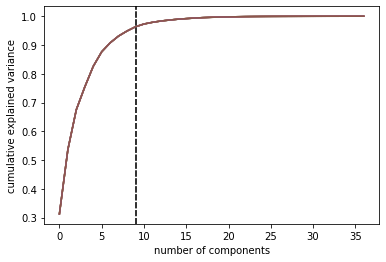

<IPython.core.display.Javascript object>

In [23]:
for config_name in model_configs_to_run:
    # get model config
    cols_to_reduce_dict = feature_dict[config_name]["cols_to_reduce_dict"]
    reduce_number_dict = feature_dict[config_name]["reduce_number_dict"]
    log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
    if_one_hot = feature_dict[config_name]["if_one_hot"]
    if_scale = feature_dict[config_name]["if_scale"]
    replace_original_feature_col_dict = feature_dict[config_name][
        "replace_original_feature_col_dict"
    ]
    resample_param_dict = feature_dict[config_name]["resample_param_dict"]
    drop_data_dict = feature_dict[config_name]["drop_data"]
    model_name = feature_dict[config_name]["model"]
    drop_data_colums = feature_dict[config_name]["drop_data_colums"]

    model = model_dict[model_name]

    # check if need to drop data
    if len(drop_data_dict) > 0:
        for one_col, drop_level_list in drop_data_dict.items():
            train_filled_df = train_filled_df.query(
                f"{one_col} not in {drop_level_list}"
            )
    # NEWLY ADDED PART TO DROP NECESSARY COLUMNS
    if len(drop_data_colums) > 0:
        train_filled_subset_df = train_filled_df.drop(columns=drop_data_colums)
        test_filled_subset_df = test_filled_df.drop(columns=drop_data_colums)

    else:
        train_filled_subset_df = train_filled_df
        test_filled_subset_df = test_filled_df
    # process data
    train_filter_df, test_filter_df, pca_cols = du.process_data_v1(
        train_filled_subset_df.drop_duplicates(),
        test_filled_subset_df.drop_duplicates(),
        reduce_col_dict=cols_to_reduce_dict,
        cols_to_log_transform=log10_transform_cols,
        reduce_number_dict=reduce_number_dict,
    )
    # Set feature columns after data transformations
    all_cols_to_reduce = []
    for _, one_set_col_to_reduce in cols_to_reduce_dict.items():
        all_cols_to_reduce = all_cols_to_reduce + one_set_col_to_reduce

    all_cols_to_drop = []
    all_cols_to_replace_from_drop = []
    for col_to_drop, col_to_replace in replace_original_feature_col_dict.items():
        all_cols_to_drop.append(col_to_drop)
        all_cols_to_replace_from_drop.append(col_to_replace)

        subset_feature_columns = (
            list(
                set(gv.all_feature_columns)
                - set(all_cols_to_reduce)
                - set(log10_transform_cols)
                - set(all_cols_to_drop)
            )
            + pca_cols
            + all_cols_to_replace_from_drop
            + [f"log10_{col}" for col in log10_transform_cols]
        )

    # NEWLY ADDED PART TO DROP NECESSARY COLUMNS
    if len(drop_data_colums) > 0:
        features_columns = list(set(subset_feature_columns) - set(drop_data_colums))
    else:
        features_columns = subset_feature_columns

    print(config_name, features_columns, if_one_hot)

    # run model
    ## Run LOY model
    model_rmse = mu.run_leave_year_out(
        model_df=train_filter_df,
        ml_model=model,
        features_columns=features_columns,
        if_scale_data=if_scale,
        if_one_hot=if_one_hot,
        model_type=model_type_dict[model_name],
        resample_param_dict=resample_param_dict,
    )
    print(f"Average RMSE:\n{model_rmse.mean()}")
    display(model_rmse)

    ## predict on test data
    if len(resample_param_dict) > 0:
        train_for_resample_df = train_filter_df
        resample_by_col = resample_param_dict["resample_by_col"]
        resample_type = resample_param_dict["resample_type"]
        if resample_param_dict["up_or_downsample"] == "upsample":
            train_filter_x_df = mu.upsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )
        elif resample_param_dict["up_or_downsample"] == "downsample":
            train_filter_x_df = mu.downsampling_by_column(
                train_for_resample_df, resample_by_col, resample_type=resample_type
            )

    train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
        train_filter_df, features_columns
    )
    test_filter_x_df = mu.split_model_feature_response(
        test_filter_df, features_columns, if_with_response=False
    )
    processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df,
        test_filter_x_df,
        if_scale,
        if_one_hot,
        full_data_df=train_filter_x_df,
    )
    run_model_dict = {
        "xgboost": mu.run_sklearn_model,
        "catboost": mu.run_catboost_model,
        "lightgbm": mu.run_lgb_model,
    }
    train_predict, test_predict, fitted_model = run_model_dict[model_name](
        model, processed_train_x_df, train_filter_y_df, processed_test_x_df
    )
    training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
    print(f"Whole data train RMSE: {training_rmse}")
    
    # Save outputs to local
    model_rmse.loc[model_rmse.shape[0], :] = [0, training_rmse, np.nan]
    model_rmse["method"] = model_rmse["left_out_year"].apply(
        lambda x: "loyo" if x > 0 else "whole train"
    )
    
    model_rmse.to_csv(
        f"{wids_path}validation_result/meng/{config_name}.csv", index=False
    )

    print(f"Average RMSE:\n{model_rmse.query('left_out_year != 0').mean()}")
    display(model_rmse)

    test_prediction_result = test_df[["id"]]
    test_prediction_result["site_eui"] = test_predict
    test_prediction_result.to_csv(
        f"{wids_path}prediction_result/meng/{config_name}_{today}.csv", index=False
    )

    if model_name == "catboost":
        viz.plot_catboost_feature_importance(model)
        plt.savefig(
            f"{wids_path}prediction_result/meng/{config_name}_feature_importance.png"
        )
        plt.close()
    elif model_name == "xgboost":
        fig, ax = plt.subplots(figsize=(15, 20))
        xgb.plot_importance(fitted_model, ax=ax)
        plt.savefig(
            f"{wids_path}prediction_result/meng/{config_name}_feature_importance.png"
        )
        plt.close()
